In [1]:
import numpy as np
import pandas as pd
import plotnine as p9

import polygraph.input, polygraph.embedding, polygraph.motifs, polygraph.models, polygraph.sequence, polygraph.utils, polygraph.visualize, polygraph.stats, polygraph.likelihood

pd.set_option('display.precision', 2)
%matplotlib inline

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Comparing synthetic and native human enhancers designed for K562 cells using Polygraph

See the yeast tutorial for much more documentation and explanation!

### Read in data

In [2]:
seqs = polygraph.input.read_seqs('human_seqs.txt', sep=",")
seqs.head(3)

,Sequence,Group
SeqID,,
seq_0,GCTCGTGAGCCGTCAAGGATGCGCTCACCATCGAGCCACACGTTGG...,FastSeqProp
seq_1,GTTCGCCCGCGCATGGAGCAACGCTCTCGTTAGGACGCTTTCGTCC...,FastSeqProp
seq_2,TTTGACAGTTCCCGCCAAAATCGGACCTAGCCGTCTCAAGGCCGAG...,FastSeqProp


In [3]:
print(seqs.Group.value_counts())

Group
FastSeqProp            2000
Simulated_Annealing    2000
AdaLead                2000
native                 2000
random                 2000
Name: count, dtype: int64


# 1. Evaluate sequence composition

## 1.1 GC Content

In [5]:
seqs['GC Content'] = polygraph.sequence.gc(seqs)
seqs.head()

,Sequence,Group,GC Content
SeqID,,,
seq_0,GCTCGTGAGCCGTCAAGGATGCGCTCACCATCGAGCCACACGTTGG...,FastSeqProp,0.55
seq_1,GTTCGCCCGCGCATGGAGCAACGCTCTCGTTAGGACGCTTTCGTCC...,FastSeqProp,0.55
seq_2,TTTGACAGTTCCCGCCAAAATCGGACCTAGCCGTCTCAAGGCCGAG...,FastSeqProp,0.51
seq_3,GCTCTTGACACGCGCGAACACGTTGAGTTTGAGCGGGACGAGATAG...,FastSeqProp,0.48
seq_4,CCTCGATCATCTTGCACGGGTACCGGTAAGTCATGAGTGTAGCGCT...,FastSeqProp,0.49


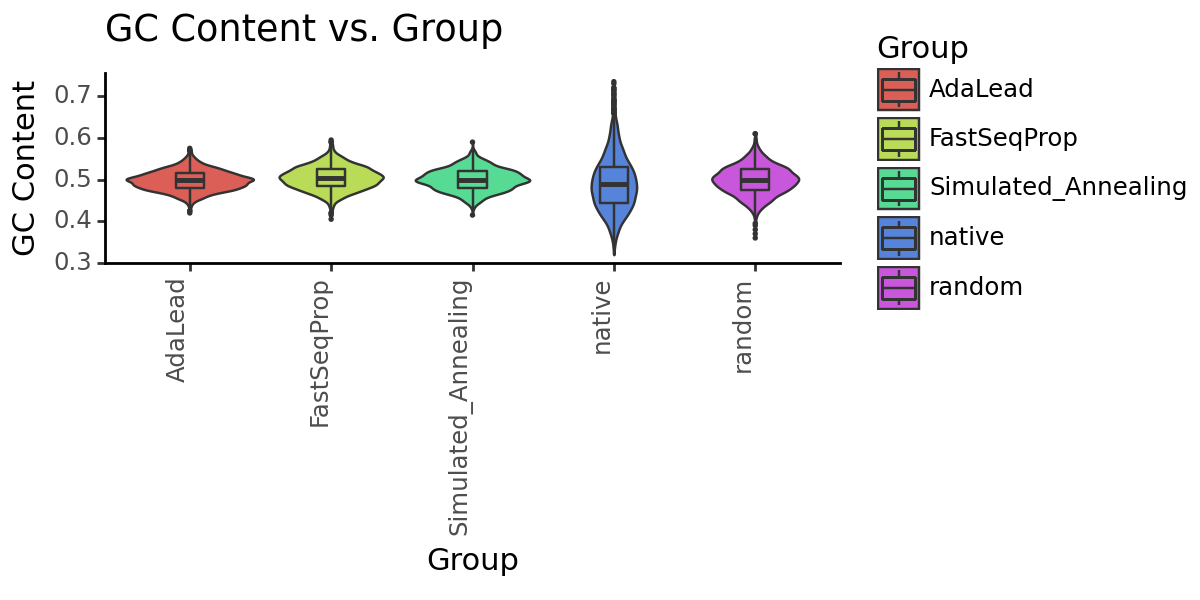

<Figure Size: (600 x 300)>

In [6]:
polygraph.visualize.boxplot(seqs, value_col='GC Content') + p9.theme(figure_size=(6, 3))

In [7]:
polygraph.stats.kruskal_dunn(data=seqs, val_col="GC Content")

{'Kruskal': 3.3631365849739994e-30,
 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing    native  \
 AdaLead              1.00e+00     4.47e-11             1.06e-02  1.33e-06   
 FastSeqProp          4.47e-11     1.00e+00             5.14e-05  1.28e-30   
 Simulated_Annealing  1.06e-02     5.14e-05             1.00e+00  1.89e-13   
 native               1.33e-06     1.28e-30             1.89e-13  1.00e+00   
 random               1.64e-01     2.11e-07             2.36e-01  4.34e-10   
 
                        random  
 AdaLead              1.64e-01  
 FastSeqProp          2.11e-07  
 Simulated_Annealing  2.36e-01  
 native               4.34e-10  
 random               1.00e+00  }

## 1.2 Sequence length distribution

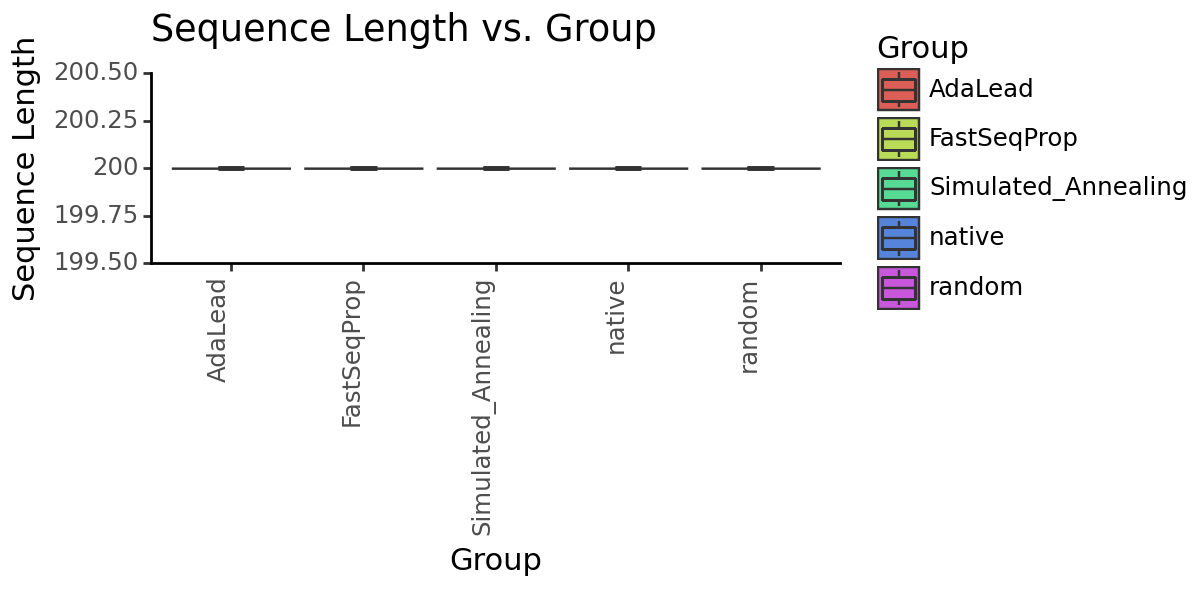

<Figure Size: (600 x 300)>

In [8]:
seqs['Sequence Length'] = seqs.Sequence.apply(len)
polygraph.visualize.boxplot(seqs, value_col='Sequence Length') + p9.theme(figure_size=(6, 3))

## 1.3 Edit distance to the nearest reference sequence

In [9]:
%%time
seqs['edit'] = polygraph.sequence.min_edit_distance_from_reference(seqs, reference_group='native')
seqs.head()

CPU times: user 3min 3s, sys: 0 ns, total: 3min 3s
Wall time: 3min 3s


,Sequence,Group,GC Content,Sequence Length,edit
SeqID,,,,,
seq_0,GCTCGTGAGCCGTCAAGGATGCGCTCACCATCGAGCCACACGTTGG...,FastSeqProp,0.55,200,97
seq_1,GTTCGCCCGCGCATGGAGCAACGCTCTCGTTAGGACGCTTTCGTCC...,FastSeqProp,0.55,200,98
seq_2,TTTGACAGTTCCCGCCAAAATCGGACCTAGCCGTCTCAAGGCCGAG...,FastSeqProp,0.51,200,100
seq_3,GCTCTTGACACGCGCGAACACGTTGAGTTTGAGCGGGACGAGATAG...,FastSeqProp,0.48,200,96
seq_4,CCTCGATCATCTTGCACGGGTACCGGTAAGTCATGAGTGTAGCGCT...,FastSeqProp,0.49,200,97


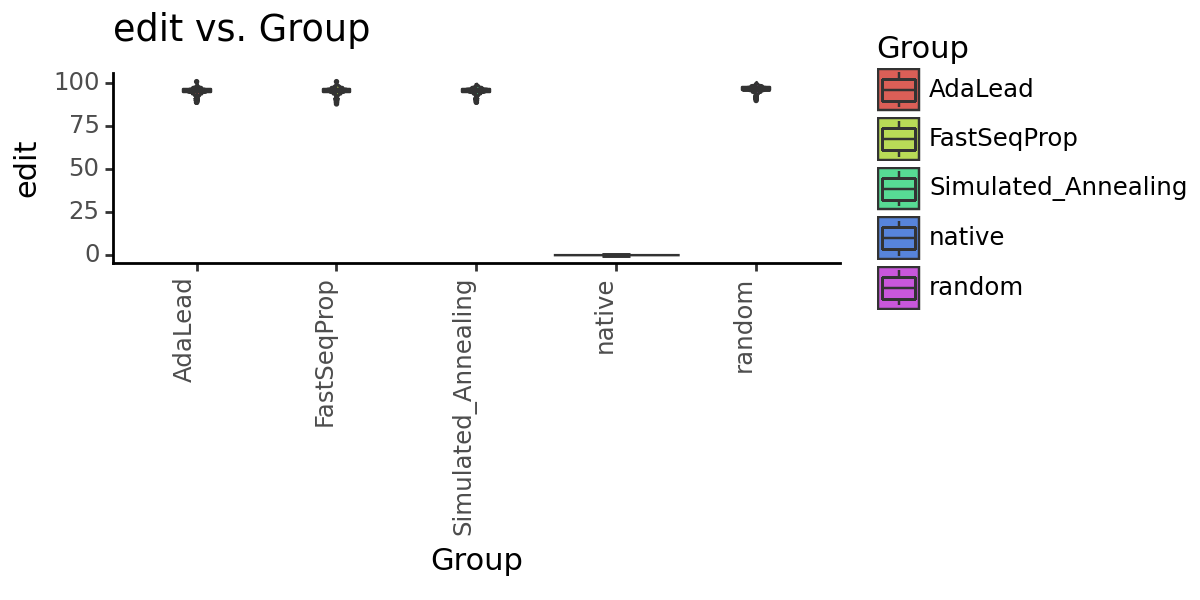

<Figure Size: (600 x 300)>

In [10]:
polygraph.visualize.boxplot(seqs, value_col='edit') + p9.theme(figure_size=(6, 3))

In [11]:
print(polygraph.stats.kruskal_dunn(data=seqs, val_col="edit"))

{'Kruskal': 0.0, 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing  native  \
AdaLead              1.00e+00     2.72e-10             1.04e-07     0.0   
FastSeqProp          2.72e-10     1.00e+00             3.12e-01     0.0   
Simulated_Annealing  1.04e-07     3.12e-01             1.00e+00     0.0   
native               0.00e+00     0.00e+00             0.00e+00     1.0   
random               9.60e-81     6.71e-37             1.14e-42     0.0   

                       random  
AdaLead              9.60e-81  
FastSeqProp          6.71e-37  
Simulated_Annealing  1.14e-42  
native               0.00e+00  
random               1.00e+00  }


## 1.4 k-mer content

### 1.4.1 Count k-mer frequency

In [3]:
%%time
kmers = polygraph.sequence.kmer_frequencies(seqs, k=5, normalize=True)
print(kmers.shape)
kmers.iloc[:5, :5]

(10000, 1024)
CPU times: user 14.8 s, sys: 530 ms, total: 15.4 s
Wall time: 15.3 s


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA
SeqID,,,,,
seq_0,0.0,0.0,0.00e+00,0.00e+00,0.00
seq_1,0.0,0.0,5.10e-03,0.00e+00,0.00
seq_2,0.0,0.0,0.00e+00,5.10e-03,0.00
seq_3,0.0,0.0,0.00e+00,0.00e+00,0.00
seq_4,0.0,0.0,0.00e+00,0.00e+00,0.01


### 1.4.2 Compute statistics

In [4]:
%%time
emb = polygraph.embedding.embedding_analysis(kmers, seqs, reference_group='native', use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.24987976011050114
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers
CPU times: user 2min 46s, sys: 24.8 s, total: 3min 11s
Wall time: 43.8 s


### 1.4.3 Visualize

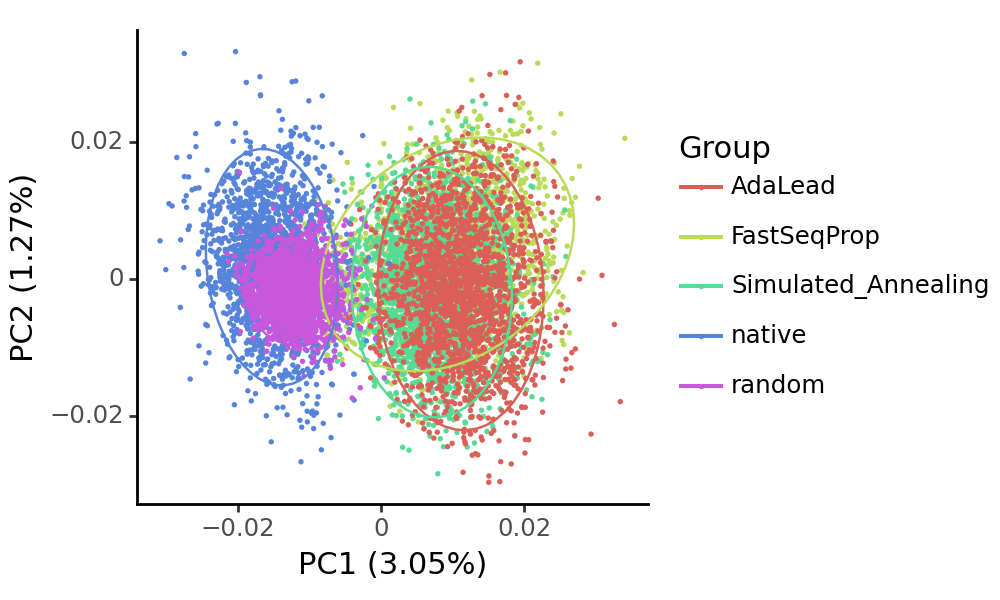

<Figure Size: (500 x 300)>

In [14]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(5, 3))

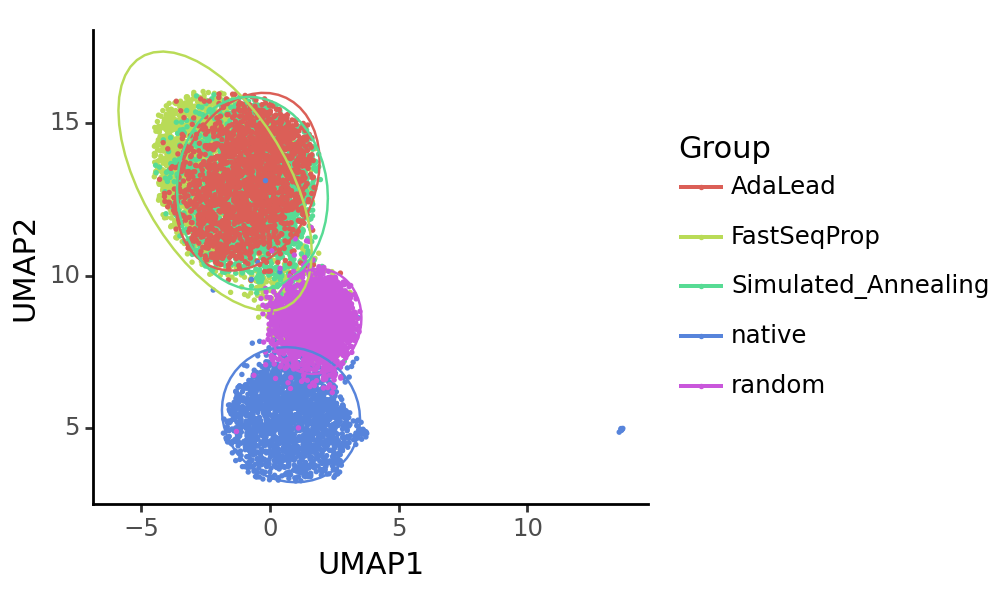

<Figure Size: (500 x 300)>

In [5]:
polygraph.visualize.umap_plot(emb, show_ellipse=True) + p9.theme(figure_size=(5, 3))

### 1.4.4 k-mer occurrence

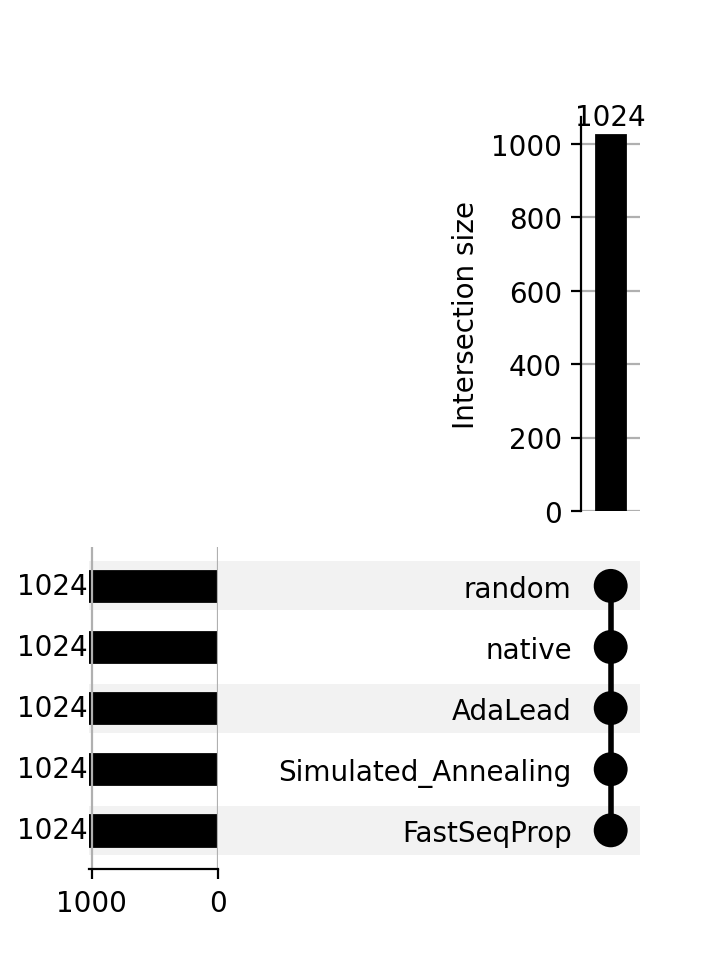

In [6]:
polygraph.visualize.upset_plot(emb)

### 1.4.5 Differential k-mer abundance

In [7]:
print("Number of differential k-mers compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential k-mers")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head())

Number of differential k-mers compared to reference
Group
random                 765
FastSeqProp            722
Simulated_Annealing    717
AdaLead                713
Name: count, dtype: int64

Top Differential k-mers
                    Group  value  score       padj  log2FC
1024          FastSeqProp  GATAA  38.48   0.00e+00    1.93
0                 AdaLead  TTATC  36.80  1.76e-293    1.91
1025          FastSeqProp  TTATC  34.04  3.17e-251    1.77
2048  Simulated_Annealing  TTATC  33.95  1.33e-249    1.76
1                 AdaLead  GATAA  33.64  2.60e-245    1.74


### 1.4.6 1-nearest neighbor fraction

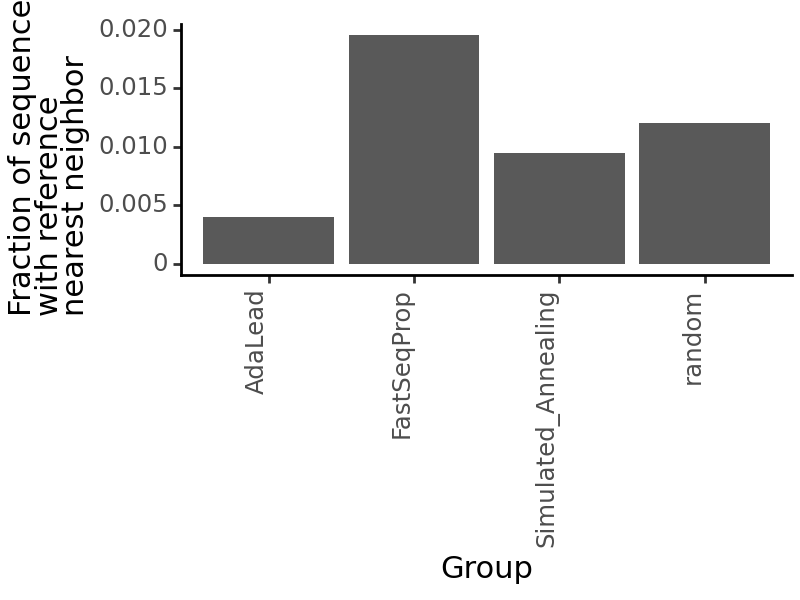

<Figure Size: (400 x 300)>

In [8]:
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native") + p9.theme(figure_size=(4,3))

In [9]:
print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

p-values for proportion of sequences with native nearest neighbor
                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp            1.95e-02      0.98   0.0   0.0
Simulated_Annealing    9.50e-03      1.00   0.0   0.0
AdaLead                4.00e-03      1.00   0.0   0.0
random                 1.20e-02      0.88   0.0   0.0


### 1.4.7 Distance to closest reference sequence

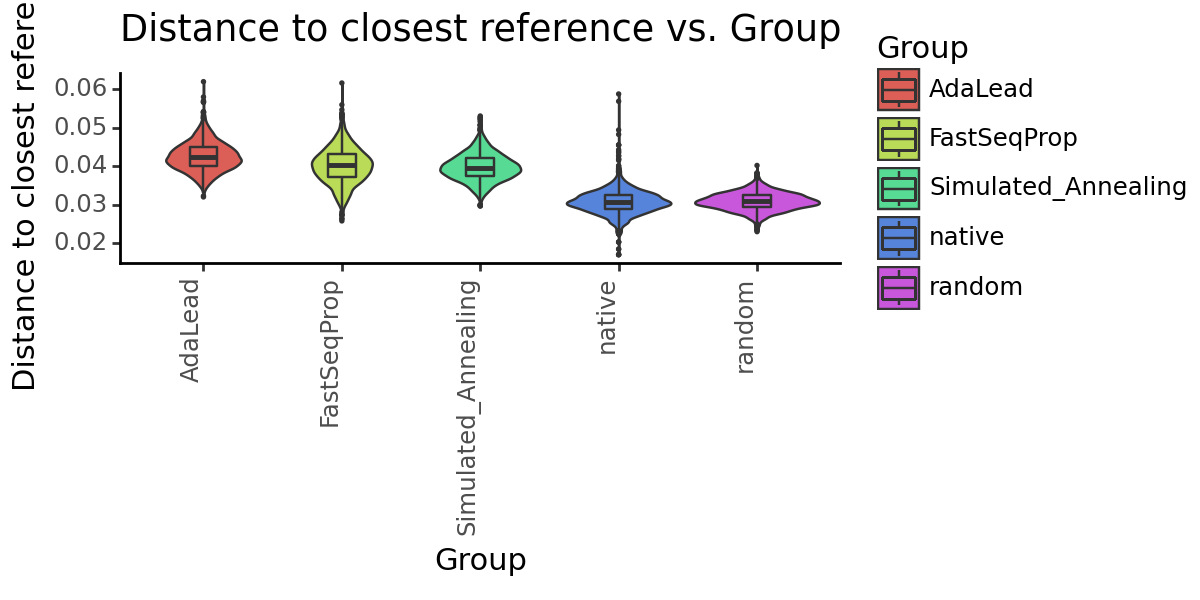

<Figure Size: (600 x 300)>

In [10]:
polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6, 3))

In [11]:
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

p-values for distance to closest reference
{'Kruskal': 0.0, 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing  native  \
AdaLead              1.00e+00     9.40e-35             1.76e-42    0.00   
FastSeqProp          9.40e-35     1.00e+00             1.89e-01    0.00   
Simulated_Annealing  1.76e-42     1.89e-01             1.00e+00    0.00   
native               0.00e+00     0.00e+00             0.00e+00    1.00   
random               0.00e+00     0.00e+00             0.00e+00    0.69   

                     random  
AdaLead                0.00  
FastSeqProp            0.00  
Simulated_Annealing    0.00  
native                 0.69  
random                 1.00  }


### 1.4.8 KNN distance (diversity metric)

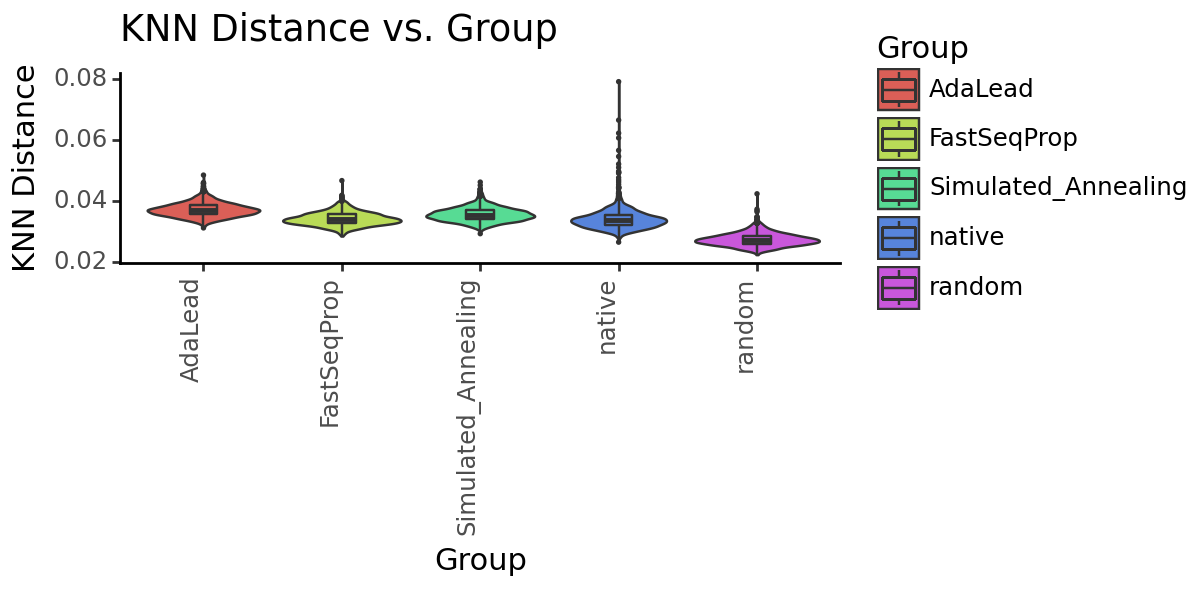

<Figure Size: (600 x 300)>

In [12]:
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6, 3))

In [13]:
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])

p-values for KNN diversity
{'Kruskal': 0.0, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing     native  \
AdaLead               1.00e+00    1.56e-186             2.10e-47  6.12e-217   
FastSeqProp          1.56e-186     1.00e+00             1.14e-48   2.07e-02   
Simulated_Annealing   2.10e-47     1.14e-48             1.00e+00   1.38e-64   
native               6.12e-217     2.07e-02             1.38e-64   1.00e+00   
random                0.00e+00     0.00e+00             0.00e+00   0.00e+00   

                     random  
AdaLead                 0.0  
FastSeqProp             0.0  
Simulated_Annealing     0.0  
native                  0.0  
random                  1.0  }


### 1.4.9 Classifier performance

In [14]:
# Performance of a classifier trained to separate each group from the reference
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
FastSeqProp,0.99,0.99
Simulated_Annealing,1.00,1.00
AdaLead,1.00,1.00
random,0.98,0.98


## 1.5 Gapped k-mer embedding

### 1.5.1 Count gapped k-mers

In [15]:
%%time
gkm = polygraph.sequence.fastsk(seqs, k=4, m=1)

Length of shortest train sequence: 200
Length of shortest test sequence: 200
Dictionary size = 4 (+1 for unknown char).
g = 4, k = 3, 3940000 features
Initializing kernel function
CPU times: user 6min 7s, sys: 15.2 s, total: 6min 23s
Wall time: 1min 46s


### 1.5.2 Compute statistics

In [16]:
%%time
emb = polygraph.embedding.embedding_analysis(
    gkm, seqs, reference_group='native', use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.9788514746966896
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers


/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/opt/conda/lib/python3.8/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinea

CPU times: user 9min 1s, sys: 22.4 s, total: 9min 23s
Wall time: 6min 47s


### 1.5.3 Visualize

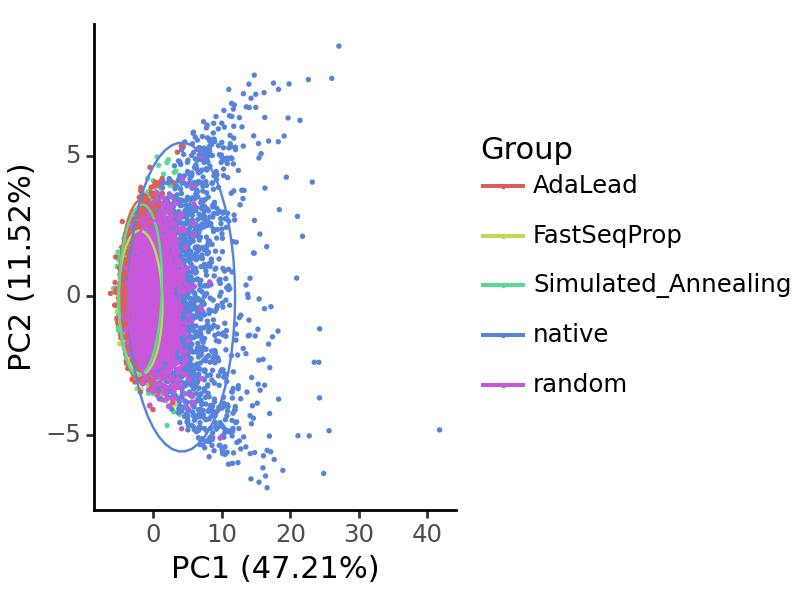

<Figure Size: (400 x 300)>

In [17]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(4,3))

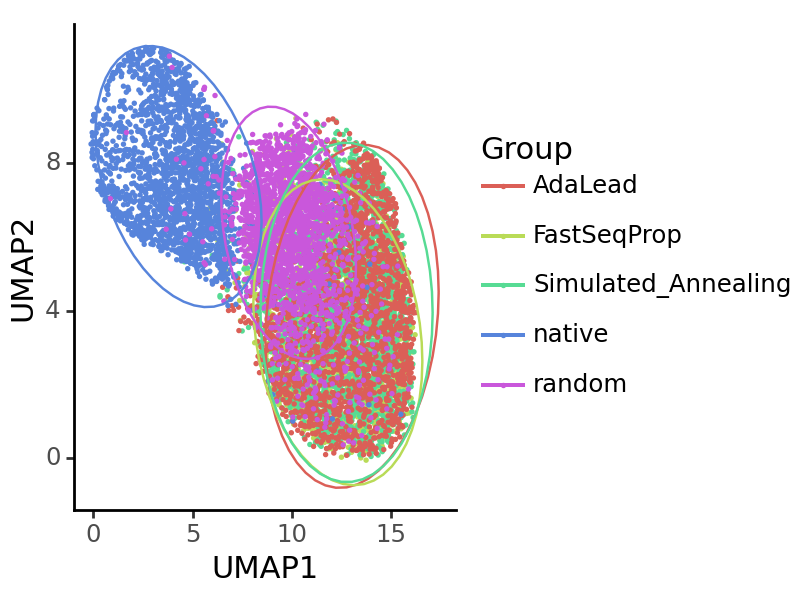

<Figure Size: (400 x 300)>

In [18]:
polygraph.visualize.umap_plot(emb, show_ellipse=True) + p9.theme(figure_size=(4,3))

### 1.5.4 Classifier performance

In [19]:
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
FastSeqProp,0.99,0.99
Simulated_Annealing,1.00,1.00
AdaLead,1.00,1.00
random,0.99,0.99


# 2. Model based evaluation

## 2.1 Load model trained on catlas scATAC-seq data

In [49]:
!wget https://zenodo.org/records/10214625/files/catlas-enformer-release-model_2.pth

--2024-01-24 20:43:38--  https://zenodo.org/records/10214625/files/catlas-enformer-release-model_2.pth
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288449775 (275M) [application/octet-stream]
Saving to: ‘catlas-enformer-release-model_2.pth’

catlas-enformer-rel 100%[===================>] 275.09M  18.1MB/s    in 17s     

2024-01-24 20:43:56 (16.2 MB/s) - ‘catlas-enformer-release-model_2.pth’ saved [288449775/288449775]



In [20]:
import torch
model = torch.load('catlas-enformer-release-model_2.pth')

## 2.2 Model predictions for 203 CATLAS cell types

In [37]:
preds = polygraph.models.predict(seqs, model, batch_size=512, device=0)
preds.shape

(10000, 203)

## 2.3 Model embeddings

### 2.3.1 Embed sequences using lower layers of model

In [38]:
embeddings = polygraph.models.get_embeddings(
    seqs.Sequence.tolist(), model.to(torch.device(0)), batch_size=512, drop_last_layers=3, swapaxes=True, device=0)
embeddings.shape

(10000, 3072)

### 2.3.2 Compute statistics

In [39]:
%%time
emb = polygraph.embedding.embedding_analysis(embeddings, seqs, reference_group='native', use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.86935663
UMAP
Differential feature abundance


/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2


1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers
CPU times: user 2min 25s, sys: 17.5 s, total: 2min 42s
Wall time: 26.7 s


### 2.3.3 Visualize

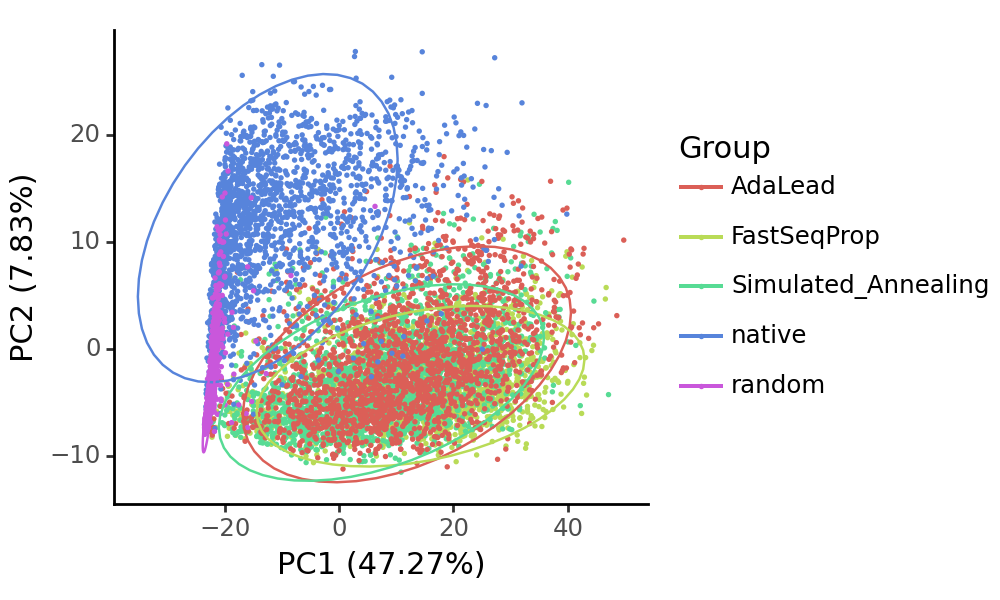

<Figure Size: (500 x 300)>

In [40]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(5, 3))

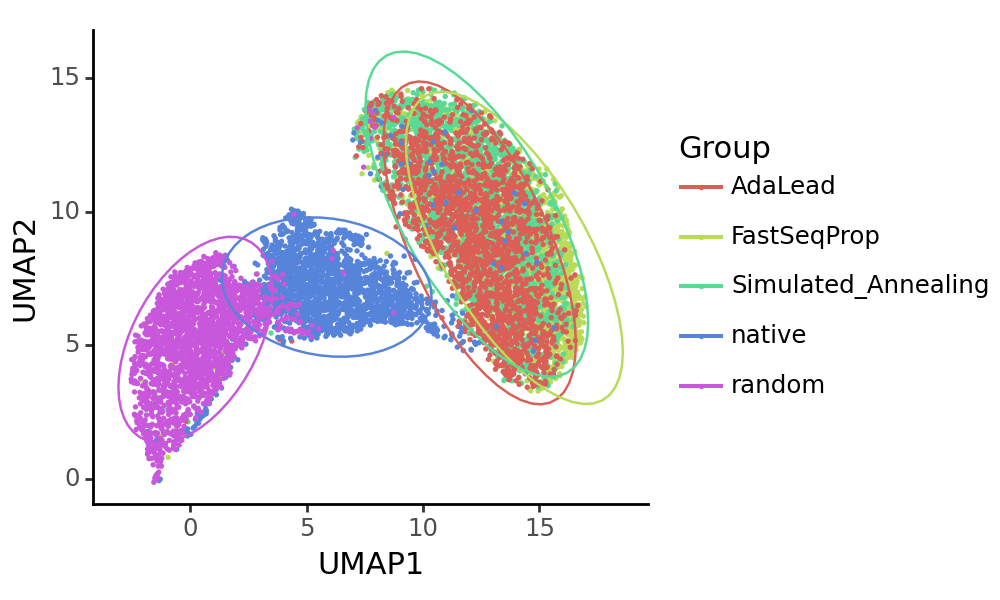

<Figure Size: (500 x 300)>

In [41]:
polygraph.visualize.umap_plot(emb, show_ellipse=True) + p9.theme(figure_size=(5, 3))

### 2.3.4 1-Nearest Neighbor Fraction

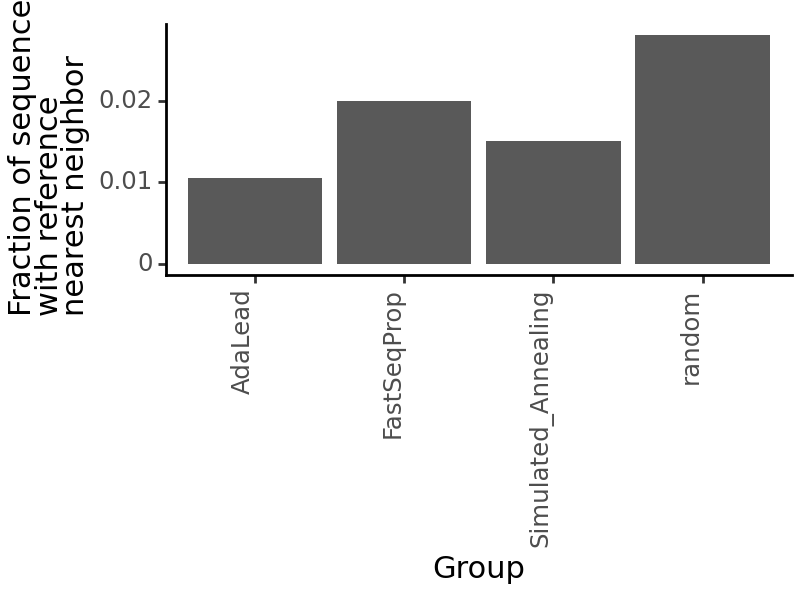

<Figure Size: (400 x 300)>

In [26]:
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native") + p9.theme(figure_size=(4,3))

In [27]:
print(emb.uns["1NN_ref_prop_test"])

                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp                0.02      0.99   0.0   0.0
Simulated_Annealing        0.01      0.99   0.0   0.0
AdaLead                    0.01      0.99   0.0   0.0
random                     0.03      0.97   0.0   0.0


### 2.3.5 Distance to nearest reference sequence

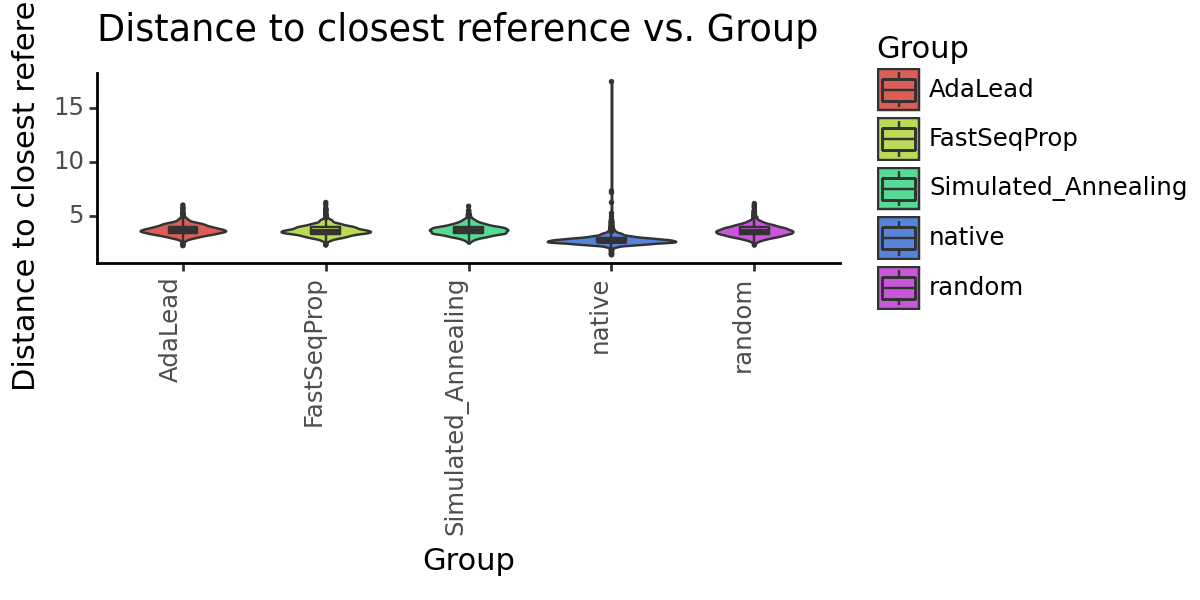

<Figure Size: (600 x 300)>

In [28]:
polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6, 3))

In [29]:
print(emb.uns['ref_dist_test'])

{'Kruskal': 0.0, 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing  native  \
AdaLead              1.00e+00     1.29e-03             5.56e-01     0.0   
FastSeqProp          1.29e-03     1.00e+00             7.92e-03     0.0   
Simulated_Annealing  5.56e-01     7.92e-03             1.00e+00     0.0   
native               0.00e+00     0.00e+00             0.00e+00     1.0   
random               1.48e-07     4.35e-02             2.74e-06     0.0   

                       random  
AdaLead              1.48e-07  
FastSeqProp          4.35e-02  
Simulated_Annealing  2.74e-06  
native               0.00e+00  
random               1.00e+00  }


### 2.3.6 KNN distance (diversity metric)

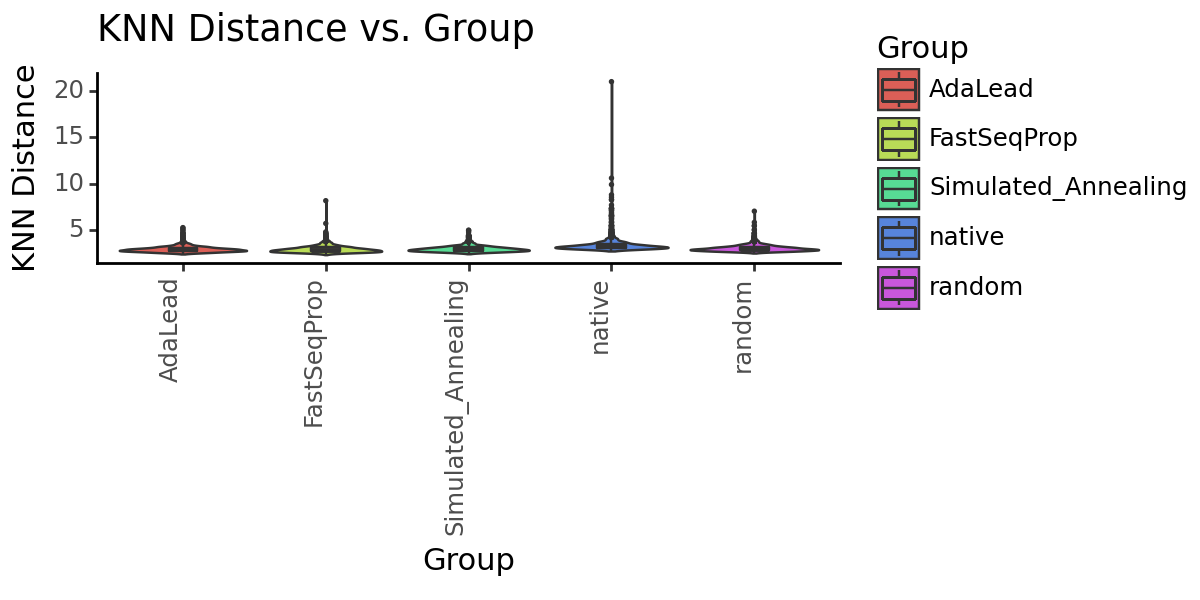

<Figure Size: (600 x 300)>

In [30]:
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6, 3))

In [31]:
print(emb.uns['knn_dist_test'])

{'Kruskal': 0.0, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing     native  \
AdaLead               1.00e+00     2.94e-01             3.95e-05  3.18e-281   
FastSeqProp           2.94e-01     1.00e+00             2.72e-07  1.61e-297   
Simulated_Annealing   3.95e-05     2.72e-07             1.00e+00  1.24e-220   
native               3.18e-281    1.61e-297            1.24e-220   1.00e+00   
random                4.54e-25     5.28e-30             5.63e-10  6.59e-143   

                        random  
AdaLead               4.54e-25  
FastSeqProp           5.28e-30  
Simulated_Annealing   5.63e-10  
native               6.59e-143  
random                1.00e+00  }


### 2.3.7 Classifier performance

In [32]:
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
FastSeqProp,0.99,0.99
Simulated_Annealing,1.00,1.00
AdaLead,1.00,1.00
random,0.99,0.99


# 3. Evaluate Motif content

## 3.1 Download JASPAR motifs and scan sequences

In [33]:
meme_file = polygraph.input.download_jaspar("vertebrates")
meme_file

--2024-03-01 21:18:50--  https://jaspar.elixir.no/download/data/2024/CORE/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt
Resolving jaspar.elixir.no (jaspar.elixir.no)... 158.39.201.109
Connecting to jaspar.elixir.no (jaspar.elixir.no)|158.39.201.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 469100 (458K) [text/plain]
Saving to: ‘/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt.1’

     0K .......... .......... .......... .......... .......... 10%  149K 3s
    50K .......... .......... .......... .......... .......... 21%  301K 2s
   100K .......... .......... .......... .......... .......... 32%  180M 1s
   150K .......... .......... .......... .......... .......... 43%  302K 1s
   200K .......... .......... .......... .......... .......... 54%  179M 1s
   250K .......... .......... .......... .......... .......... 65%  318M 0s
   300K .......... .......... .......... .....

'/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt'

In [70]:
%%time 
sites = polygraph.motifs.scan(seqs, '/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt')

Read 879 motifs from file.
CPU times: user 3min 33s, sys: 392 ms, total: 3min 34s
Wall time: 3min 34s


## 3.2 Filter by TF expression in whole blood according to GTeX

We could use all 879 motifs, but for this example we are going to download GTeX expression data and use it to filter to motifs for TFs expressed in whole blood.

In [43]:
gtex = polygraph.input.load_gtex_tpm()

File already exists at /opt/conda/lib/python3.8/site-packages/polygraph/resources/gtex/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz


In [44]:
gtex.head()

,Name,Description,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,ENSG00000223972.5,DDX11L1,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.00
1,ENSG00000227232.5,WASH7P,4.06,3.37,2.69,4.05,3.9,3.64,5.16,1.44,...,5.93,6.13,4.19,5.93,3.06,4.70,6.27,7.19,5.75,2.65
2,ENSG00000278267.1,MIR6859-1,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,ENSG00000243485.5,MIR1302-2HG,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00
4,ENSG00000237613.2,FAM138A,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [71]:
blood_tfs = gtex.loc[gtex['Whole Blood'] > 1, 'Description']
all_tfs = sites.MotifID.str.upper()
selected_tfs = set(all_tfs).intersection(blood_tfs)
len(selected_tfs)

311

In [72]:
sites = sites[sites.MotifID.isin(selected_tfs)]

## 3.1 Motif count embedding

### 3.1.1 Count motifs

In [73]:
counts = polygraph.motifs.motif_frequencies(sites, seqs=seqs, normalize=True)
counts.iloc[:5, :5]

,ATF2,ATF3,ATF4,ATF6,ATF7
SeqID,,,,,
seq_0,0.00e+00,0.00e+00,0.0,0.00e+00,0.0
seq_1,5.00e-03,0.00e+00,0.0,0.00e+00,0.0
seq_2,0.00e+00,0.00e+00,0.0,5.00e-03,0.0
seq_3,0.00e+00,0.00e+00,0.0,0.00e+00,0.0
seq_4,0.00e+00,5.00e-03,0.0,0.00e+00,0.0


### 3.1.2 Compute statistics

In [74]:
%%time
emb = polygraph.embedding.embedding_analysis(counts, seqs, reference_group='native', use_pca=True)

Creating AnnData object
PCA
Fraction of total variance explained by PCA components:  0.6873481267967111
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
Train groupwise classifiers
CPU times: user 1min 54s, sys: 37.9 s, total: 2min 32s
Wall time: 19.9 s


### 3.1.3 Visualize

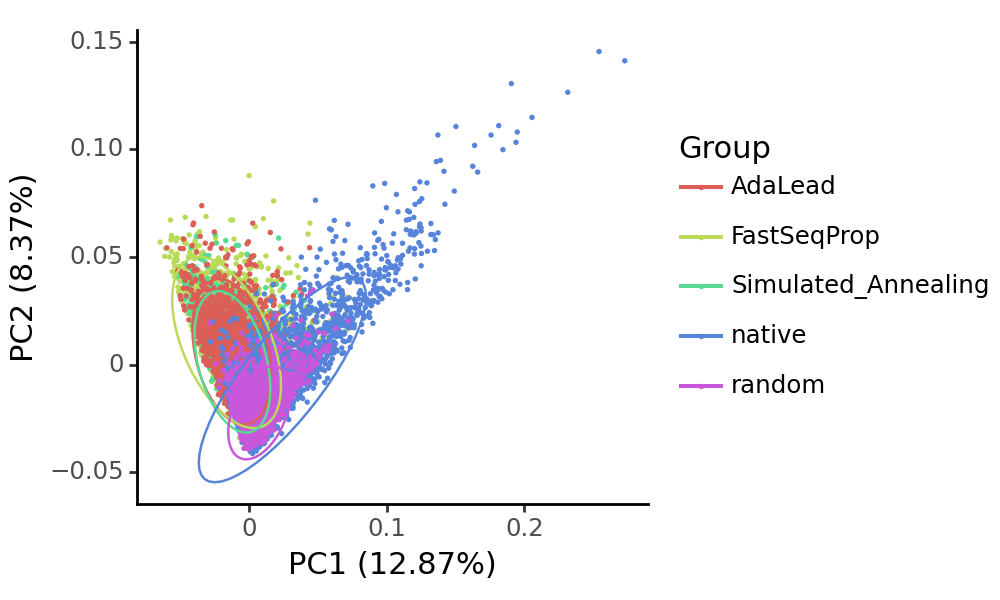

<Figure Size: (500 x 300)>

In [75]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(5, 3))

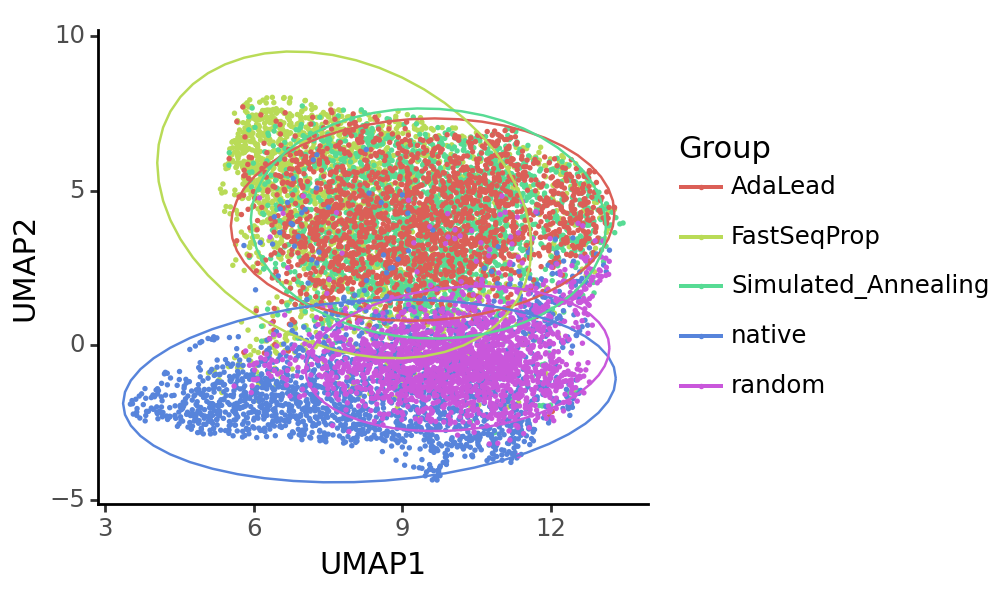

<Figure Size: (500 x 300)>

In [76]:
polygraph.visualize.umap_plot(emb, show_ellipse=True) + p9.theme(figure_size=(5, 3))

### 3.1.4 Motif occurrence

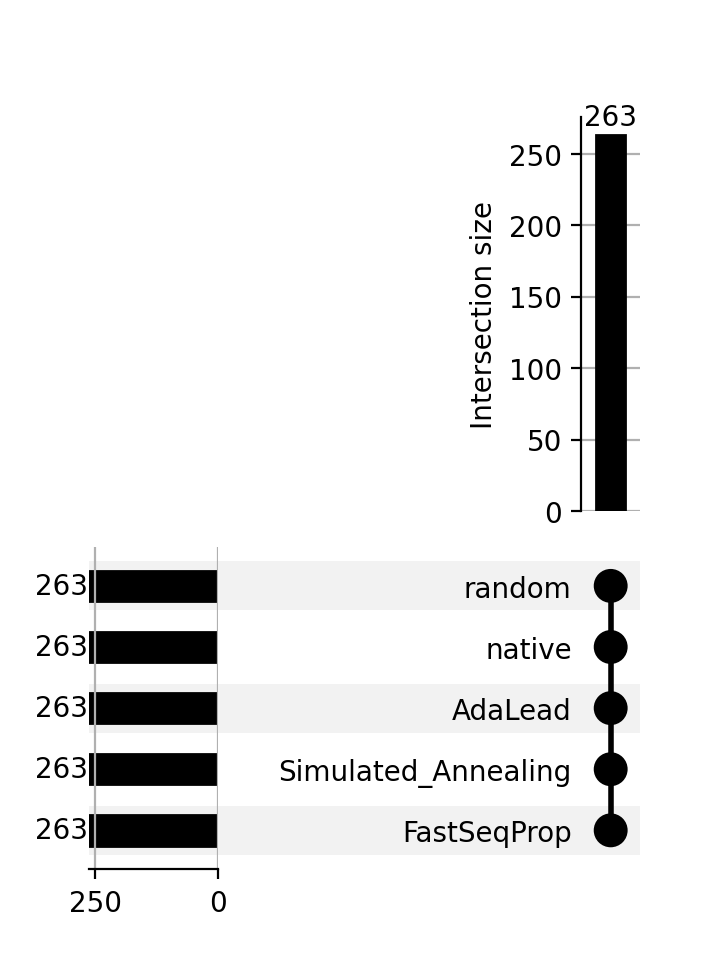

In [77]:
polygraph.visualize.upset_plot(emb)

### 3.1.5 Differential motif abundance

In [78]:
print("Number of differential motifs compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential motifs")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head())

Number of differential motifs compared to reference
Group
AdaLead                226
Simulated_Annealing    226
FastSeqProp            213
random                 201
Name: count, dtype: int64

Top Differential motifs
                   Group  value  score  padj  log2FC
0                AdaLead  TRPS1  43.97   0.0    1.54
1                AdaLead  TBX21  39.53   0.0    2.12
2                AdaLead  GATA1  37.73   0.0    1.66
263          FastSeqProp  TRPS1  42.22   0.0    1.59
526  Simulated_Annealing  TRPS1  39.68   0.0    1.33


### 3.1.6 1-Nearest Neighbor Fraction

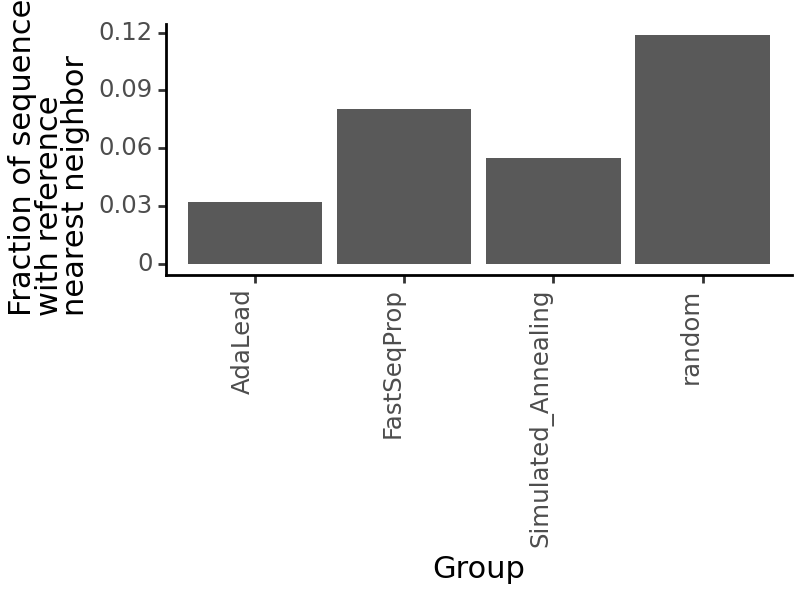

<Figure Size: (400 x 300)>

In [79]:
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native") + p9.theme(figure_size=(4,3))

In [80]:
print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

p-values for proportion of sequences with native nearest neighbor
                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp                0.08      0.93   0.0   0.0
Simulated_Annealing        0.06      0.94   0.0   0.0
AdaLead                    0.03      0.96   0.0   0.0
random                     0.12      0.75   0.0   0.0


### 3.1.7 Distance to closest reference sequence

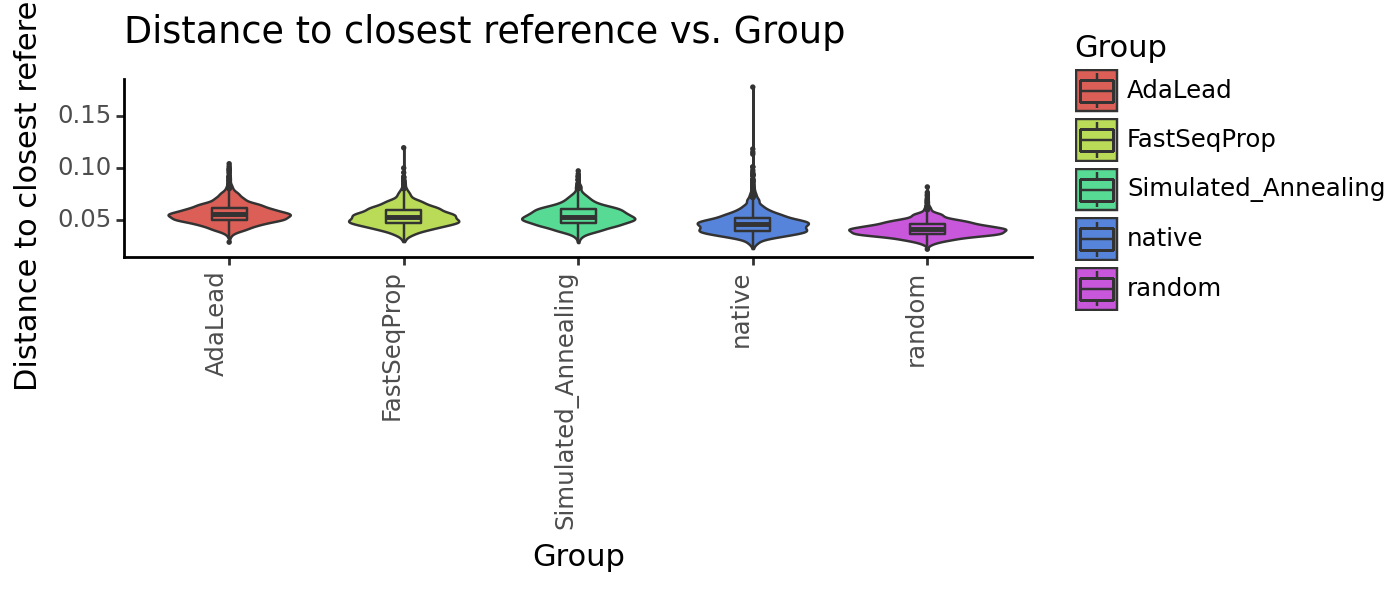

<Figure Size: (700 x 300)>

In [81]:
polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(7, 3))

In [82]:
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

p-values for distance to closest reference
{'Kruskal': 0.0, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing     native  \
AdaLead               1.00e+00     1.01e-14             1.02e-10  6.58e-183   
FastSeqProp           1.01e-14     1.00e+00             1.98e-01   1.17e-98   
Simulated_Annealing   1.02e-10     1.98e-01             1.00e+00  9.39e-111   
native               6.58e-183     1.17e-98            9.39e-111   1.00e+00   
random                0.00e+00    7.67e-299             0.00e+00   1.35e-56   

                        random  
AdaLead               0.00e+00  
FastSeqProp          7.67e-299  
Simulated_Annealing   0.00e+00  
native                1.35e-56  
random                1.00e+00  }


### 3.1.8 K-Nearest Neighbor distance (diversity metric)

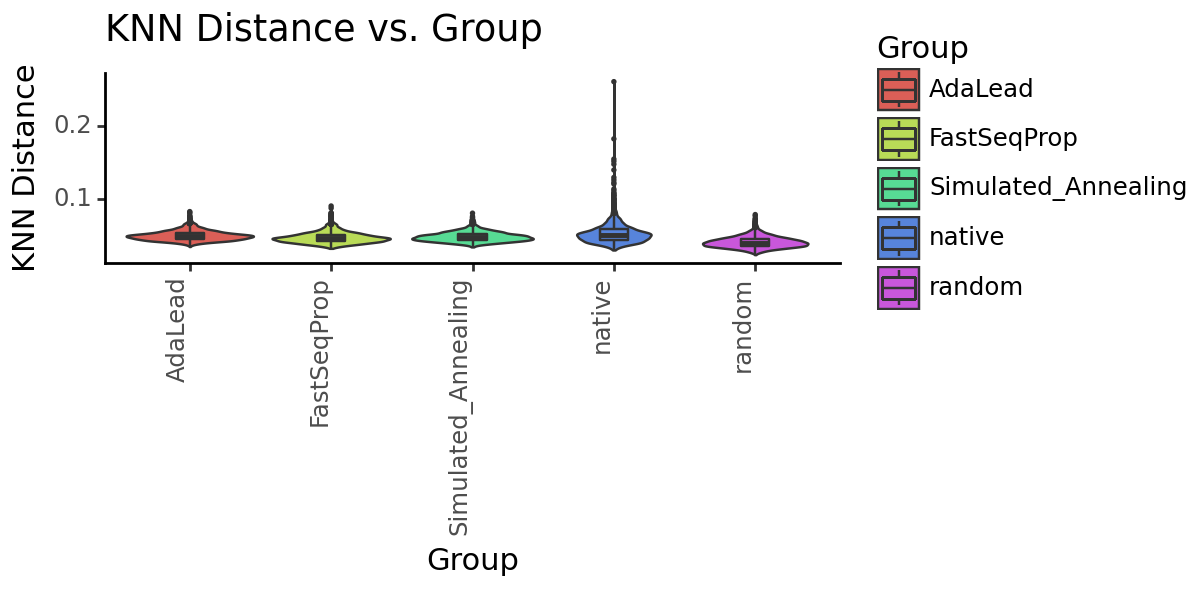

<Figure Size: (600 x 300)>

In [83]:
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6, 3))

In [84]:
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])

p-values for KNN diversity
{'Kruskal': 0.0, 'Dunn':                        AdaLead  FastSeqProp  Simulated_Annealing    native  \
AdaLead               1.00e+00     6.59e-36             1.99e-10  2.21e-02   
FastSeqProp           6.59e-36     1.00e+00             8.37e-10  1.65e-49   
Simulated_Annealing   1.99e-10     8.37e-10             1.00e+00  5.45e-18   
native                2.21e-02     1.65e-49             5.45e-18  1.00e+00   
random               2.29e-276    8.02e-117            1.52e-186  0.00e+00   

                        random  
AdaLead              2.29e-276  
FastSeqProp          8.02e-117  
Simulated_Annealing  1.52e-186  
native                0.00e+00  
random                1.00e+00  }


### 3.1.9 Classifier performance

In [85]:
emb.uns['svm_performance']

,Accuracy,AUROC
Group,,
FastSeqProp,0.96,0.96
Simulated_Annealing,0.98,0.98
AdaLead,0.99,0.99
random,0.93,0.93


## 3.2 Motif positions

In [87]:
print(polygraph.stats.kruskal_dunn(sites[sites.MotifID=='GATA1'], val_col='start'))

{'Kruskal': 9.235286326359694e-22, 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing    native  \
AdaLead              1.00e+00     5.15e-01             4.77e-04  1.00e-12   
FastSeqProp          5.15e-01     1.00e+00             2.93e-03  4.91e-12   
Simulated_Annealing  4.77e-04     2.93e-03             1.00e+00  3.60e-06   
native               1.00e-12     4.91e-12             3.60e-06  1.00e+00   
random               4.00e-12     1.62e-11             6.22e-07  2.11e-01   

                       random  
AdaLead              4.00e-12  
FastSeqProp          1.62e-11  
Simulated_Annealing  6.22e-07  
native               2.11e-01  
random               1.00e+00  }


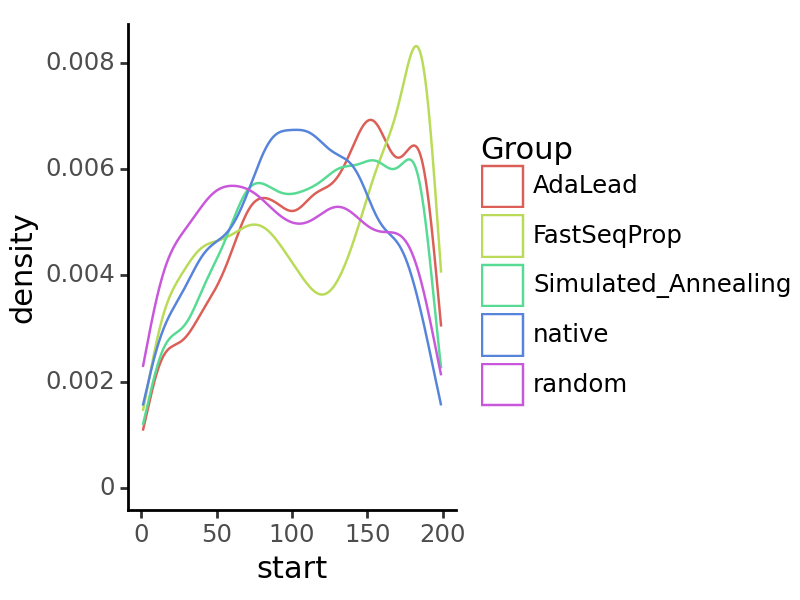

<Figure Size: (400 x 300)>

In [88]:
polygraph.visualize.densityplot(sites[sites.MotifID=='GATA1'], value_col='start') + p9.theme(figure_size=(4,3))

## 3.3 Motif pair syntax

We will identify co-occurring pairs of motifs. This can take a long time, so for speed we use only the first 50 motifs.

### 3.3.1 Find motif pairs

In [89]:
sel_motifs = sites.MotifID.unique()[:50]
sel_sites = sites[sites.MotifID.isin(sel_motifs)].copy()

In [ ]:
%%time
motif_pairs = polygraph.motifs.get_motif_pairs(sel_sites)
motif_pairs.head()

### 3.3.2 Differential abundance of motif pairs

In [92]:
pair_diff_abundance = polygraph.motifs.motif_pair_differential_abundance(
    motif_pairs, seqs, reference_group="native", max_prop_cutoff=0.25)

pair_diff_abundance.head()

Selected 239 pairs based on in-group proportion


,Group,group_prop,ref_prop,log2FC,pval,padj,MotifID
0,FastSeqProp,0.14,0.35,-1.34,2.37e-56,5.45e-56,"(ELF4, ZBTB11)"
1,Simulated_Annealing,0.09,0.35,-1.97,4.55e-93,2.09e-92,"(ELF4, ZBTB11)"
2,AdaLead,0.08,0.35,-2.22,3.11e-107,1.89e-106,"(ELF4, ZBTB11)"
3,random,0.24,0.35,-0.52,1.65e-13,2.05e-13,"(ELF4, ZBTB11)"
4,FastSeqProp,0.09,0.38,-2.08,1.44e-109,9.29e-109,"(ELF4, GABPA)"


In [93]:
print("Number of differential motif pairs compared to reference")
print(pair_diff_abundance[pair_diff_abundance.padj < .01].Group.value_counts())

print("")

print("Top Differential motif pairs")
print(pair_diff_abundance[pair_diff_abundance.padj < .01].sort_values('padj').head())

Number of differential motif pairs compared to reference
Group
random                 229
Simulated_Annealing    228
AdaLead                225
FastSeqProp            222
Name: count, dtype: int64

Top Differential motif pairs
           Group  group_prop  ref_prop  log2FC       pval       padj  \
152  FastSeqProp        0.73      0.13    2.51   0.00e+00   0.00e+00   
154      AdaLead        0.68      0.13    2.42  1.44e-298  6.86e-296   
150      AdaLead        0.06      0.49   -3.15  2.10e-234  6.69e-232   
790      AdaLead        0.04      0.44   -3.58  7.03e-226  1.68e-223   
914      AdaLead        0.04      0.45   -3.37  5.39e-218  1.03e-215   

            MotifID  
152  (GATA1, GATA1)  
154  (GATA1, GATA1)  
150  (GABPA, IKZF1)  
790   (ELK4, IKZF1)  
914   (ELF1, IKZF1)  


### 3.3.3 Differentially oriented motif pairs

In [94]:
pair_diff_orientation = polygraph.motifs.motif_pair_differential_orientation(
    motif_pairs, seqs, reference_group="native", ref_prop_cutoff=0.2)

pair_diff_orientation.head()

Selected 328 pairs based on in-group proportion


,Group,group_prop,ref_prop,log2FC,pval,padj,MotifID
0,FastSeqProp,0.53,0.53,1.41e-02,0.89,0.97,"(ELF4, RXRB)"
1,Simulated_Annealing,0.48,0.53,-1.37e-01,0.24,0.45,"(ELF4, RXRB)"
2,AdaLead,0.50,0.53,-8.43e-02,0.46,0.67,"(ELF4, RXRB)"
3,random,0.53,0.53,-5.42e-03,0.96,1.00,"(ELF4, RXRB)"
4,FastSeqProp,0.48,0.43,1.53e-01,0.14,0.30,"(ELF4, ZNF75A)"


In [95]:
print("Number of differentially oriented motif pairs compared to reference")
print(pair_diff_orientation[pair_diff_orientation.padj <= .01].Group.value_counts())

print("")

print("Top Differentially oriented motif pairs")
print(pair_diff_orientation[pair_diff_orientation.padj <= .01].sort_values('padj').head())

Number of differentially oriented motif pairs compared to reference
Group
random                 69
Simulated_Annealing    48
FastSeqProp            48
AdaLead                38
Name: count, dtype: int64

Top Differentially oriented motif pairs
                   Group  group_prop  ref_prop  log2FC      pval      padj  \
840          FastSeqProp        0.57      0.74   -0.37  4.67e-17  6.12e-14   
268          FastSeqProp        0.50      0.66   -0.41  3.77e-15  2.47e-12   
841  Simulated_Annealing        0.56      0.74   -0.40  1.35e-14  5.90e-12   
288          FastSeqProp        0.48      0.35    0.45  9.33e-14  3.06e-11   
264          FastSeqProp        0.42      0.29    0.53  1.67e-13  4.39e-11   

              MotifID  
840    (KLF10, KLF10)  
268  (ZNF707, ZNF75A)  
841    (KLF10, KLF10)  
288   (KLF10, ZNF75A)  
264   (ZNF707, KLF10)  


### 3.3.4 Differentially spaced motif pairs

In [97]:
pair_diff_dist = polygraph.motifs.motif_pair_differential_distance(
    motif_pairs, seqs, reference_group="native", ref_prop_cutoff=0.2)

pair_diff_dist.head()

Selected 328 pairs based on in-group proportion


,index,Group,group_mean,ref_mean,log2FC,pval,padj,MotifID
0,0,FastSeqProp,60.05,60.71,-0.02,0.54,0.73,"(ELF4, RXRB)"
1,0,Simulated_Annealing,62.79,60.71,0.05,0.45,0.66,"(ELF4, RXRB)"
2,0,AdaLead,61.49,60.71,0.02,0.98,0.99,"(ELF4, RXRB)"
3,0,random,59.37,60.71,-0.03,0.34,0.55,"(ELF4, RXRB)"
4,0,FastSeqProp,64.58,59.64,0.11,0.07,0.18,"(ELF4, ZNF75A)"


In [98]:
sig_diff_dist = pair_diff_dist[(pair_diff_dist.padj <= .01) & (pair_diff_dist.ref_mean > 5)]

print("Number of differentially spaced motif pairs compared to reference")
print(sig_diff_dist.Group.value_counts())

print("")

print("Top Differentially spaced motif pairs")
print(sig_diff_dist.sort_values('padj').head())

Number of differentially spaced motif pairs compared to reference
Group
AdaLead                72
FastSeqProp            59
Simulated_Annealing    58
random                 41
Name: count, dtype: int64

Top Differentially spaced motif pairs
     index                Group  group_mean  ref_mean  log2FC      pval  \
640      0          FastSeqProp       16.24     35.63   -1.13  1.08e-34   
641      0  Simulated_Annealing       18.50     35.63   -0.95  9.03e-34   
182      0              AdaLead       27.09     36.07   -0.41  5.37e-33   
642      0              AdaLead       19.30     35.63   -0.88  1.06e-28   
643      0               random       24.85     35.63   -0.52  1.16e-21   

         padj        MotifID  
640  1.41e-31  (ELF1, GABPA)  
641  5.92e-31  (ELF1, GABPA)  
182  2.35e-30   (MAFK, JUND)  
642  3.47e-26  (ELF1, GABPA)  
643  3.04e-19  (ELF1, GABPA)  


## 3.4 NMF

In [99]:
%%time
W, H, test_results = polygraph.motifs.nmf(counts, seqs, reference_group='native', n_components=10)

/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.


CPU times: user 1min 28s, sys: 4.21 s, total: 1min 32s
Wall time: 1.19 s


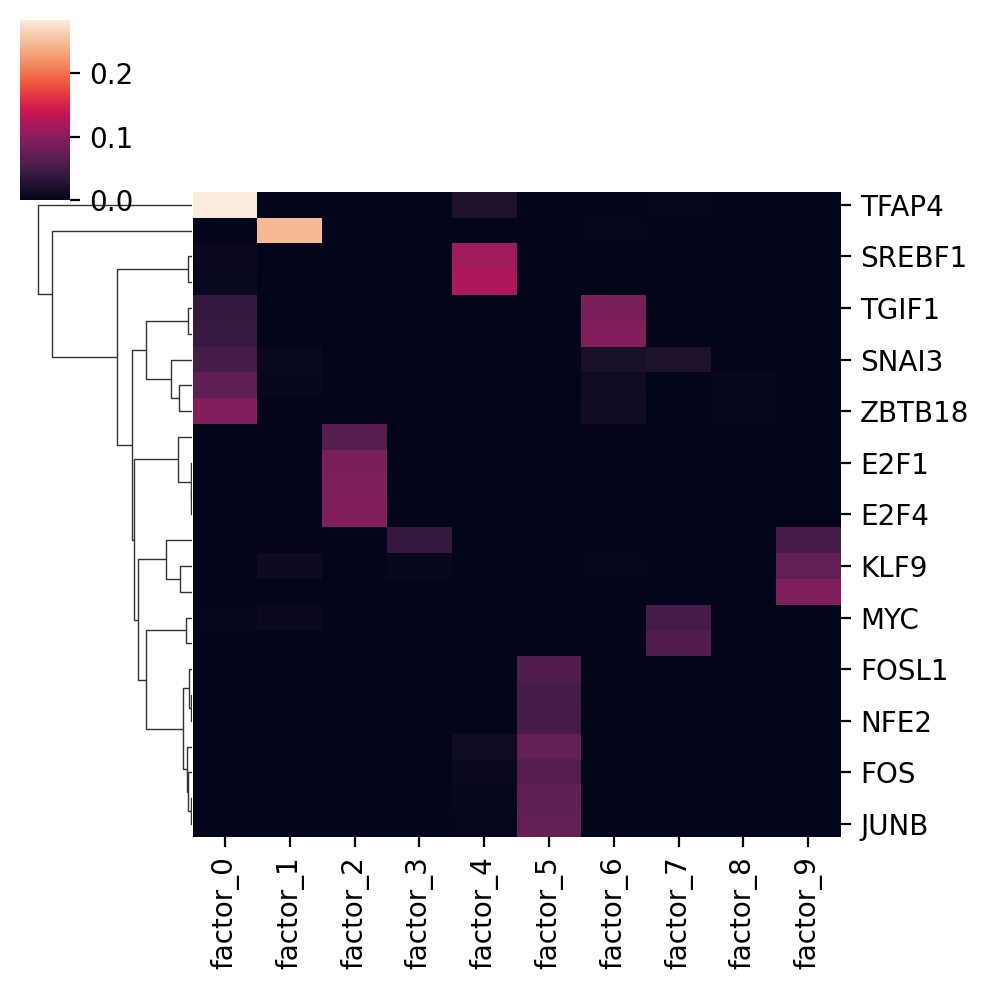

In [100]:
# Motifs that contribute to each factor
polygraph.visualize.plot_factors_nmf(H, n_features=25, figsize=(5,5))

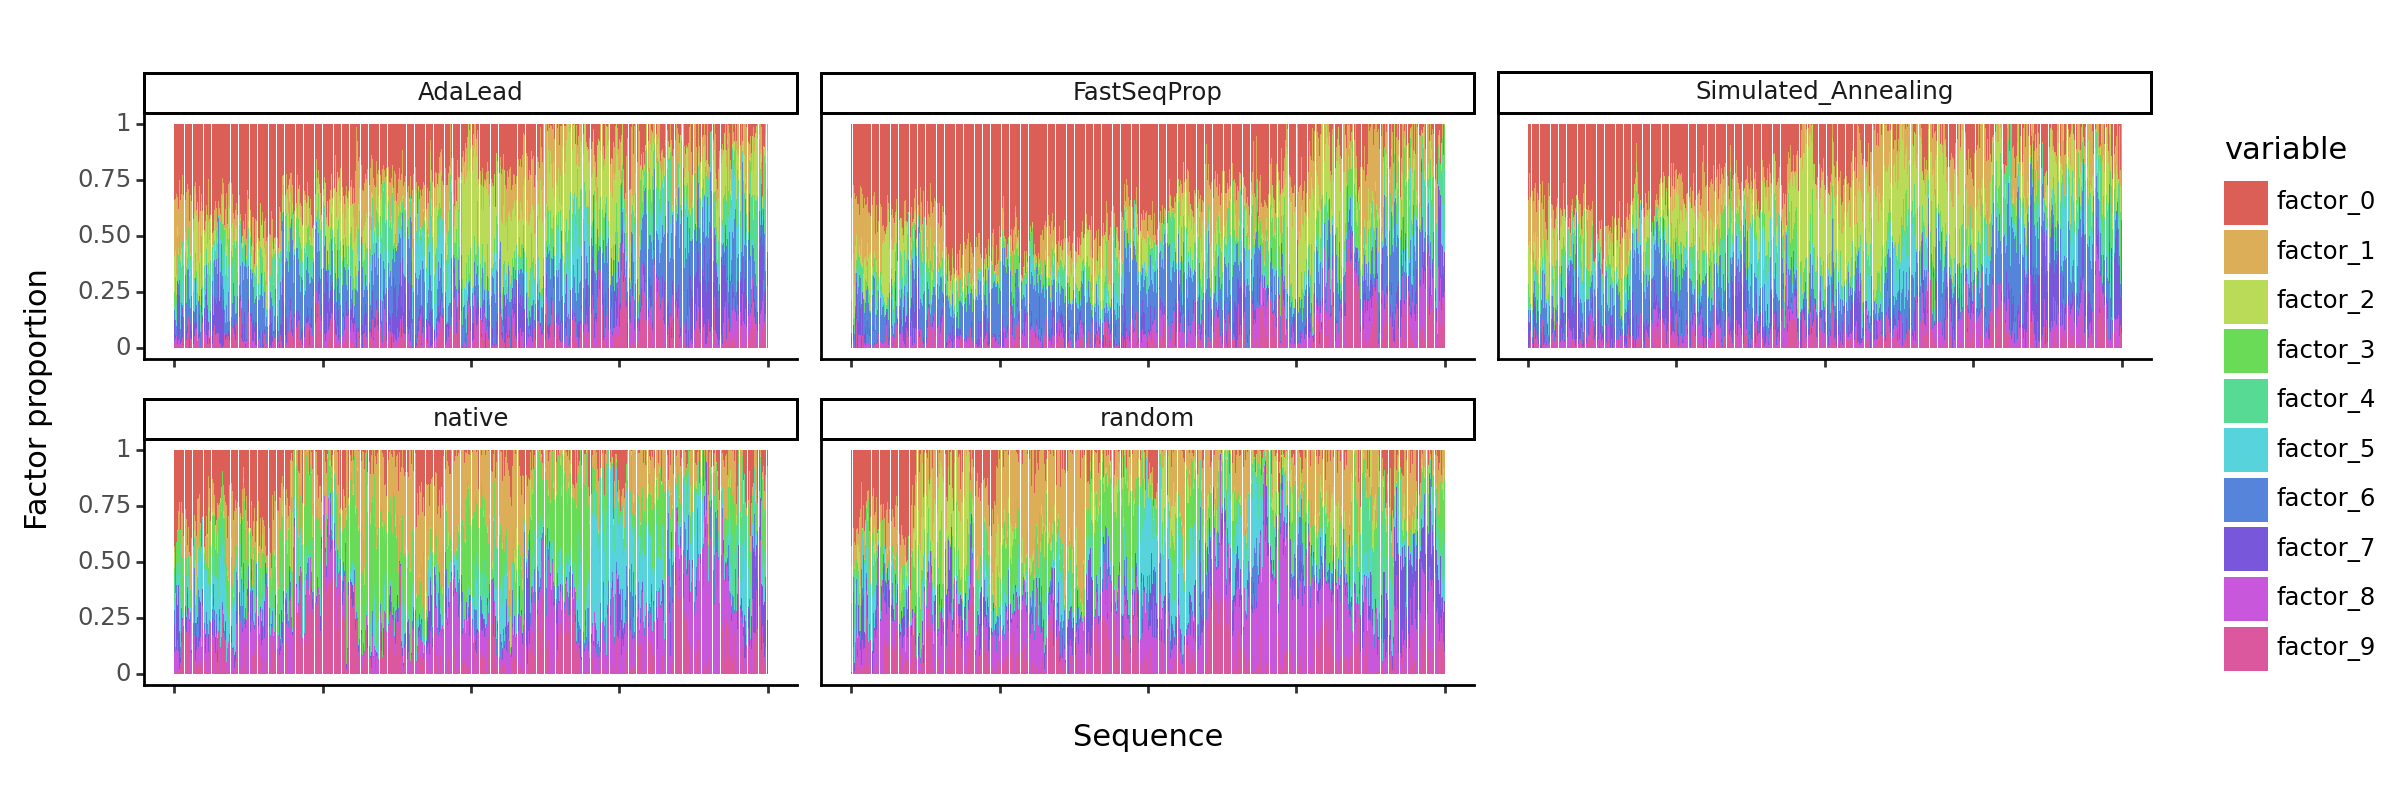

<Figure Size: (1200 x 400)>

In [101]:
polygraph.visualize.plot_seqs_nmf(W) + p9.theme(figure_size=(12, 4))

In [102]:
test_results.head()

,Group,group_mean,ref_mean,log2FC,pval,padj,factor
0,FastSeqProp,0.11,0.03,1.99,3.83e-288,1.91e-287,factor_0
0,Simulated_Annealing,0.06,0.03,1.13,1.27e-92,2.55e-92,factor_0
0,AdaLead,0.06,0.03,1.23,1.02e-115,2.56e-115,factor_0
0,random,0.01,0.03,-1.04,5.92e-53,1.13e-52,factor_0
0,FastSeqProp,0.04,0.05,-0.37,2.52e-06,2.66e-06,factor_1


In [103]:
# How many factors contribute differently in each synthetic group vs. the reference?
test_results[test_results.padj < .01].Group.value_counts()

Group
FastSeqProp            10
Simulated_Annealing    10
AdaLead                10
random                 10
Name: count, dtype: int64

# 4. Language model likelihood calculation

In [104]:
# Substitute '/hyena-dna' with the path to your cloned hyena-dna repository
# See https://github.com/HazyResearch/hyena-dna for instructions to clone and install hyenadna
model = polygraph.likelihood.load_hyenadna(hyena_path='/hyena-dna')

Loading config
Building model
Loading weights


In [105]:
log_likelihood = polygraph.likelihood.compute_likelihood(
    seqs, model, num_workers=8, device=0)
seqs['log_likelihood'] = log_likelihood

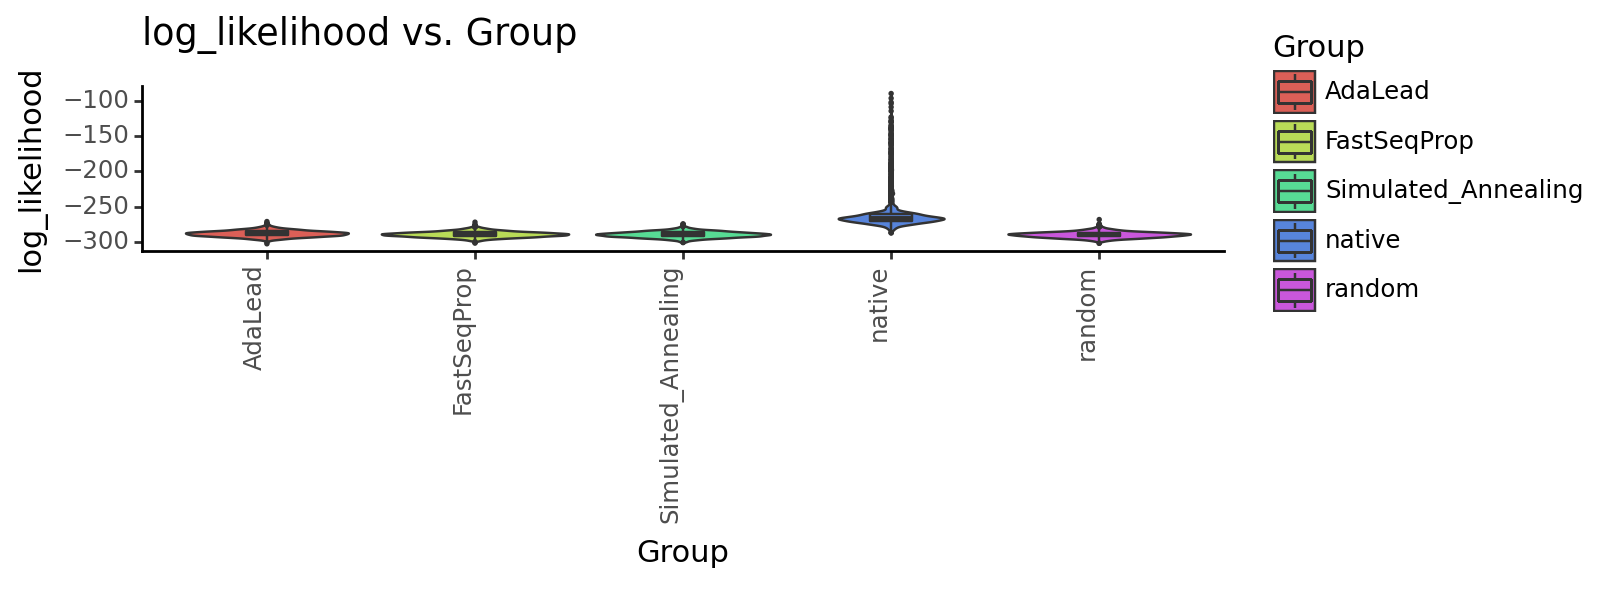

<Figure Size: (800 x 300)>

In [106]:
polygraph.visualize.boxplot(seqs, group_col="Group", value_col="log_likelihood") + p9.theme(figure_size=(8, 3))